## PS 2

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from numpy import *
np.seterr(divide='ignore', invalid='ignore')
import statsmodels.api as sm

In [2]:
bq_data = np.loadtxt("BQmat_orig.txt", delimiter=",")

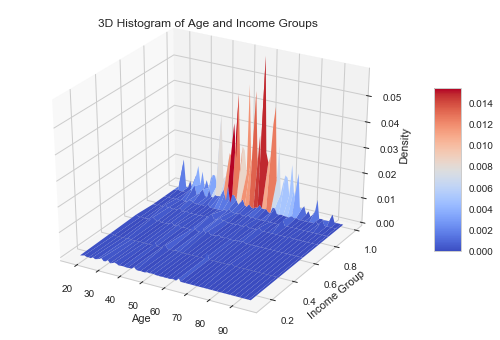

In [3]:
# Problem 1a 
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
age_vec = np.arange(18, 96)
inc_vec = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
inc_mat, age_mat = np.meshgrid(inc_vec, age_vec)
surf = ax.plot_surface(age_mat, inc_mat, bq_data, cmap=cm.coolwarm)
plt.title("3D Histogram of Age and Income Groups")
plt.xlabel("Age")
plt.ylabel("Income Group")
ax.set_zlabel("Density")
fig.colorbar(surf, shrink=0.5, aspect=6)
plt.show()

In [4]:
# Problem 1b
# Use cross-validation to find out the optimal bandwidth
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': 10*np.linspace(0, 1.0, 100)},
                    cv=10) # 10-fold cross-validation
grid.fit(bq_data[:, ])
print(grid.best_params_)
bandwidth = grid.best_params_["bandwidth"]

prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of income group values
for income, num_j in zip(inc_vec, income_probs):
    vec_inc_j = np.ones(num_j)
    vec_inc_j *= income
    inc_freq = np.append(inc_freq, vec_inc_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

coords = np.vstack([item.ravel() for item in [age_mat, inc_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

{'bandwidth': 0.10101010101010102}


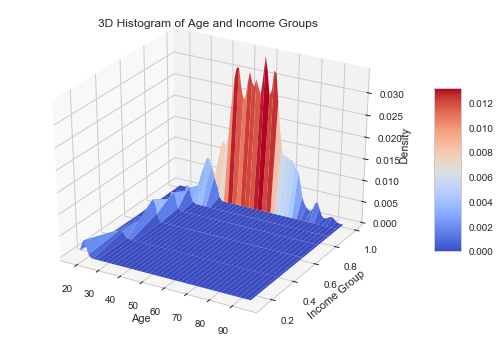

In [5]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(age_mat, inc_mat, BQkde_scaled, cmap=cm.coolwarm)
plt.title("3D Histogram of Age and Income Groups")
plt.xlabel("Age")
plt.ylabel("Income Group")
ax.set_zlabel("Density")
fig.colorbar(surf1, shrink=0.5, aspect=6)
plt.show()

In [6]:
BQkde_scaled[42, 5]

1.3575174928168473e-06

Here, I use a 10-fold cross validation to find the optimal bandwidth, the optimal bandwidth I picked is 0.1010. The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 1.36e-06. 

In [7]:
# Problem 2.a
dta = pd.read_csv("biden.csv")
dta['age_educ'] = dta['age']*dta['educ']
dta.head()

,biden,female,age,educ,dem,rep,age_educ
0,90.0,0,19.0,12.0,1.0,0.0,228.0
1,70.0,1,51.0,14.0,1.0,0.0,714.0
2,60.0,0,27.0,14.0,0.0,0.0,378.0
3,50.0,1,43.0,14.0,1.0,0.0,602.0
4,60.0,1,38.0,14.0,0.0,1.0,532.0


In [8]:
y = dta['biden']
X = sm.add_constant(dta.iloc[:,[2,3,6]])

In [9]:
fit = sm.OLS(y, X, missing='drop', hasconst=True)
res = fit.fit()
print(fit.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        10:50:40   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5491      9.491      3.956      0.0

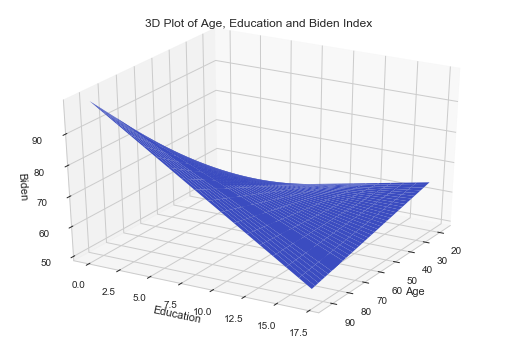

In [10]:
age_vals = np.array(sorted(dta.age.unique()))
educ_vals = np.array(sorted(dta.educ.unique()))
educ1, age1 = np.meshgrid(educ_vals, age_vals)
biden1 = 37.5491 + 0.6674*age1 + 1.7123*educ1 - 0.0477*age1*educ1
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age1, educ1, biden1, cmap=cm.coolwarm)
plt.title("3D Plot of Age, Education and Biden Index")
plt.xlabel("Age")
plt.ylabel("Education")
ax.set_zlabel("Biden")
#plt.show()
ax.view_init(30, 30)
plt.draw()
plt.pause(.001)

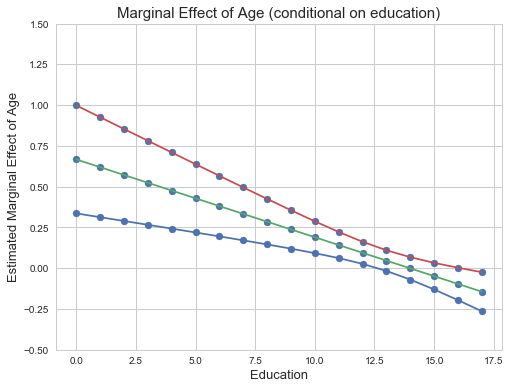

In [11]:
gb1 = dta.groupby('educ')
values_educ = gb1.groups.keys()
b_hat_age = res.params['age']
b_hat_inter = res.params['age_educ']
cov_matrix = res.cov_params()
var_age = cov_matrix.iloc[1][1]
var_inter = cov_matrix.iloc[3][3]
cov_age_inter = cov_matrix.iloc[1][3]

exp_marg_eff0 = []
exp_marg_eff = []
value_list = []

for i in values_educ:
    marg_eff = b_hat_age + b_hat_inter * i 
    se = math.sqrt(var_age + i**2 * var_inter + 2 * i * cov_age_inter)
    ymin_95 = marg_eff - 1.96 * se
    ymax_95 = marg_eff + 1.96 * se
    exp_marg_eff.append([ymin_95, marg_eff, ymax_95])
    exp_marg_eff0.append(marg_eff)
    value_list.append([int(i)]*3)

plt.figure(figsize=(8,6))
plt.scatter(value_list, exp_marg_eff)
plt.plot(value_list, exp_marg_eff)

plt.title('Marginal Effect of Age (conditional on education)', fontsize=15)
plt.xlabel('Education', fontsize=13)
plt.ylabel('Estimated Marginal Effect of Age', fontsize=13)
plt.ylim(-0.5, 1.5)
plt.grid(True, which='both')
plt.show()

The marginal effect of age on the biden thermometer conditional on education is 0.66 - 0.0477*education. The marginal effect decreases as the education level increases, and with less than 14 years of education, the marginal effect of age on the thermometer is always positive. However, as the education level continue to increase, the marginal effeect becomes negative. All of the three parameters are statistically significant. This trend can also be seen from the graph above.  

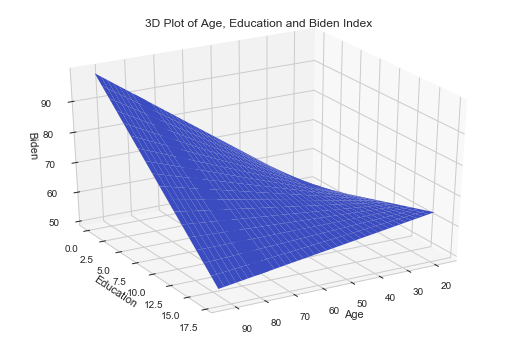

In [12]:
# problem 2b. 
age_vals = np.array(sorted(dta.age.unique()))
educ_vals = np.array(sorted(dta.educ.unique()))
educ1, age1 = np.meshgrid(educ_vals, age_vals)
biden1 = 37.5491 + 0.6674*age1 + 1.7123*educ1 - 0.0477*age1*educ1
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age1, educ1, biden1, cmap=cm.coolwarm)
plt.title("3D Plot of Age, Education and Biden Index")
plt.xlabel("Age")
plt.ylabel("Education")
ax.set_zlabel("Biden")
#plt.show()
ax.view_init(30, 60)
plt.draw()
plt.pause(.001)

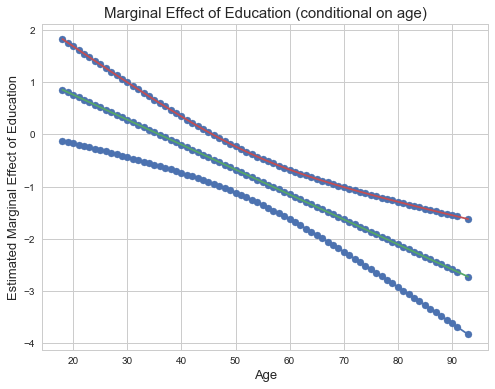

In [13]:
gb2 = dta.groupby('age')
values_age = gb2.groups.keys()
b_hat_educ = res.params['educ']
var_educ = cov_matrix.iloc[2][2]
cov_educ_inter = cov_matrix.iloc[2][3]

exp_marg_eff1 = []
exp_marg_eff2 = []
value_list1 = []

for i in values_age:
    marg_eff = b_hat_educ + b_hat_inter * i 
    se = math.sqrt(var_educ + i**2 * var_inter + 2 * i * cov_educ_inter)
    ymin_95 = marg_eff - 1.96 * se
    ymax_95 = marg_eff + 1.96 * se
    exp_marg_eff2.append([ymin_95, marg_eff, ymax_95])
    exp_marg_eff1.append(marg_eff)
    value_list1.append([int(i)]*3)

plt.figure(figsize=(8,6))
plt.scatter(value_list1, exp_marg_eff2)
plt.plot(value_list1, exp_marg_eff2)

plt.title('Marginal Effect of Education (conditional on age)', fontsize=15)
plt.xlabel('Age', fontsize=13)
plt.ylabel('Estimated Marginal Effect of Education', fontsize=13)
plt.grid(True, which='both')
plt.show()


Similar to part a, the marginal effect of education on biden thermometer conditional on age is 1.7123-0.0477*age. When age is less than 36, the marginal effect is positive, while when age is no less than 36 the effect is negative. The marginal effect on biden index is expected to be lower if age level increases.  